# The Dacc (Data Accessor)

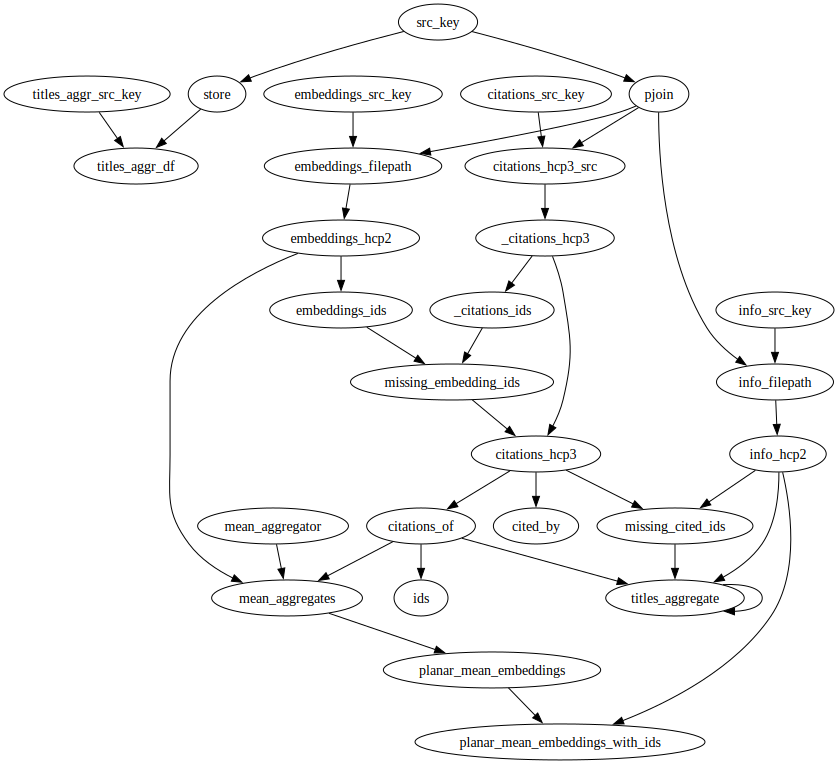

In [44]:
from i2.footprints import attribute_dependencies, init_argument_names
from imbed.mdat.hcp import Hcp3Dacc
from meshed.itools import graphviz_digraph

deps = dict(attribute_dependencies(Hcp3Dacc))

graphviz_digraph(deps)

In [5]:
rootdir = '/Users/thorwhalen/Dropbox/_odata/figiri/hcp'

In [6]:
from imbed.mdat.hcp import Hcp3Dacc

dacc = Hcp3Dacc(rootdir)

# Computing embeddings of aggregated titles

In [45]:
dacc.titles_aggr_df

,id,title,abstract,source,pub_date,n_cits,micro_cluster,main_field,title_references
0,245658,Standardized low-resolution brain electromagne...,Scalp electric potentials (electroencephalogra...,PubMed,2002-01-01,1056,241,Biomedical and health sciences,Review of methods for solving the EEG inverse ...
1,332595,Electrokinetic migration across artificial liq...,Basic drug substances were transported across ...,Journal of Chromatography A,2006-03-01,570,180,Physical sciences and engineering,β-Lactamase Recovery from E. coli Cell Lysate ...
2,718838,Pathophysiology of obsessive–compulsive disorder,Obsessive-compulsive disorder (OCD) is charact...,Progress in Neurobiology,2004-02-01,304,1123,Biomedical and health sciences,Elevated medial-frontal cerebral blood flow in...
3,804345,Der Kinder- und Jugendgesundheitssurvey (KiGGS...,"From May 2003 to May 2006, the Robert Koch Ins...",Bundesgesundheitsblatt - Gesundheitsforschung ...,2007-05-01,358,3022,Biomedical and health sciences,Das Landesmodul Schleswig-Holstein im Rahmen d...
4,831416,Remote Ischemic Preconditioning Provides Early...,The aim of this study was to characterize the ...,Journal of the American College of Cardiology,2005-08-01,370,1057,Biomedical and health sciences,Sites of action of adenosine in interorgan pre...
...,...,...,...,...,...,...,...,...,...
354160,4386007333,Retroperitoneal fibrosis,Retroperitoneal fibrosis encompasses a range o...,The Lancet,2006-01-01,340,1576,Biomedical and health sciences,The HLA System | RETROPERITONEAL FIBROSIS | Mo...
354161,4386007350,The epidemiology of skin cancer,Journal Article The epidemiology of skin cance...,British Journal of Dermatology,2002-04-01,685,1306,Biomedical and health sciences,Mortality from Melanoma in Migrants to Austral...
354162,4386007683,Risk Factors for Cerebral Edema in Children wi...,Cerebral edema is an uncommon but devastating ...,The New England Journal of Medicine,2001-01-25,415,1171,Biomedical and health sciences,Malignant Cerebral Edema and Intracranial Hype...
354163,4386008405,Idarucizumab for Dabigatran Reversal,Specific reversal agents for non–vitamin K ant...,The New England Journal of Medicine,2015-08-06,828,65,Biomedical and health sciences,The Effect of Dabigatran Plasma Concentrations...


In [79]:
import dol

kt = dol.KeyTemplate(
    'data_{num:02.0f}.parquet', 
    field_patterns=dict(num='[0-9]+'),
    from_str_funcs=dict(num=int)
)
f = kt.key_codec(decoded='single', encoded='str')



'data_123.parquet'

In [82]:
def id_title_aggre_gen(dacc, sep='\n\n###\n\n'):
    data = dacc.titles_aggr_df.set_index('id')[['title', 'title_references']].dropna()
    for id, d in data.iterrows():
        titles = d['title'] + sep + d['title_references']
        yield id, titles

k, v = next(iter(id_title_aggre_gen(dacc)))

In [181]:
import pandas as pd
df = pd.DataFrame([{'id': k, 'titles_aggr': v} for k, v in id_title_aggre_gen(dacc)])

In [182]:
# This took over 4m for me.
max_tokens = 8192

import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")

n_tokens = dol.Pipe(encoding.encode, len)

df['n_tokens'] = df['titles_aggr'].apply(n_tokens)
print(f"Before: {len(df)}")
df = df[df['n_tokens'] <= max_tokens]
print(f"After: {len(df)}")  # > 4mn for me

Before: 346804
After: 342855


In [110]:
# import pandas as pd

# TODO: Finish this storification of the process

# def write_parquet(obj) -> bytes:
#     return pd.to_parquet(obj)

# def mk_vector_store(dacc, folder_name: str):
#     import dol

#     folder_path = dacc.pjoin(dacc.rootdir, folder_name)
#     # ensure folder exists
#     if not dacc.exists(folder_path):
#         dacc.mkdir(folder_path)

#     kt = dol.KeyTemplate(
#         'data_{num}.parquet',
#         field_patterns=dict(num='[0-9]+'),
#         to_str_funcs=dict(num=str),
#         from_str_funcs=dict(num=int)
#     )
#     f = kt.key_codec(decoded='tuple', encoded='str')

#     dol.wrap_kvs(
#         id_of_key=lambda key: f.encoder(key[0]),
#         key_of_id=lambda id: f.decoder(id)[0],
#         data_of_obj=lambda obj: pd.write_parquet(obj)
#         dol.Files(folder_path)
#     )

from imbed import fixed_step_chunker

from lkj import return_error_info_on_error, ErrorInfo
import oa
import pandas as pd
from typing import Optional, Callable

@return_error_info_on_error
def _process_chunk(
    dacc, i, chunk, *, log_func=print, 
    save_key: Optional[Callable]=lambda i: f"data_{i:02.0f}.parquet"
):
    if log_func:
        log_func(i)
    ids, strings = zip(*chunk)
    vectors = oa.embeddings(strings)
    ids_and_vectors_df = pd.DataFrame({'id': ids, 'vector': vectors})
    if save_key:
        filepath = dacc.pjoin('tmp', save_key(i))
        # save ids and vectors to parquet
        ids_and_vectors_df.to_parquet(filepath)
    # return False  # meaning no error


@return_error_info_on_error
def process_chunks(chunks):
    errors = []
    for i, chunk in enumerate(chunks):
        result = _process_chunk(dacc, i, chunk)
        if isinstance(result, ErrorInfo):
            errors.append(result)


chk_size = 2_000
# chunks = fixed_step_chunker(zip(df['id'], df['titles_aggr']), chk_size=chk_size, return_tail=True)
# process_chunks(chunks)  # this took several hours and cost $8.32

### Taking care of a request-to-big problem

Got this problem on chunk 169:

Error processing chunk 169: Error code: 429 - {'error': {'message': 'Request too large for text-embedding-3-small in organization org-AY3lr3H3xB9yPQ0HGR498f9M on tokens per min (TPM): Limit 5000000, Requested 5105632. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


In [93]:
from itertools import islice

chunks = fixed_step_chunker(zip(df['id'], df['titles_aggr']), chk_size=chk_size)

t = list(islice(chunks, 169, None))
assert len(t) == 2, "The assumption that there's only 2 chunks left (126 and 179) is wrong"
chunk_169 = t[0]
len(chunk_169)  # 2000

In [186]:
# umap_2d_embeddings

chunks = fixed_step_chunker(
    zip(df['id'], df['titles_aggr']), chk_size=chk_size, return_tail=True
)
t = list(islice(chunks, 170, None))
print(len(t))  # 2
print(len(t[0]))  # 2000
print(len(t[1]))  # ?

tail_chunk = t[1]

2
2000
855


In [187]:
from functools import partial
_process_chunk_without_saving = partial(_process_chunk, save_key=None)


# df1 = _process_chunk_without_saving(169.1, chunk_169[:1000])
# df2 = _process_chunk_without_saving(169.2, chunk_169[1000:])
# df_1_and_2 = pd.concat([df1, df2])
# i = 169
# filepath = dacc.pjoin('tmp', f"data_{i:02.0f}.parquet")

i = 171
df3 = _process_chunk_without_saving(i, tail_chunk)
filepath = dacc.pjoin('tmp', f"data_{i:02.0f}.parquet")
df3.to_parquet(filepath)



Processing chunk 171


### aggregating the results

In [129]:
# offload and reload dol to get the latest version

import dol
import importlib
importlib.reload(dol)



<module 'dol' from '/Users/thorwhalen/Dropbox/py/proj/i/dol/dol/__init__.py'>

In [ ]:
import io
import dol
from dol import wrap_kvs, Files, filt_iter
import pandas as pd


key_codec = dol.KeyTemplate(
    'data_{num:02.0f}.parquet', 
    field_patterns=dict(num='[0-9]+'),
    from_str_funcs=dict(num=int)
).key_codec(decoded='single', encoded='str')


wrapper = dol.Pipe(
    wrap_kvs(
        key_codec=key_codec, 
        obj_of_data=dol.Pipe(io.BytesIO, pd.read_parquet)
    ),
)

s = wrapper(Files(dacc.pjoin('tmp')))
print(f"{len(s)=}")
list(s)[:5]


In [13]:
import io
import dol
from dol import wrap_kvs, Files, filt_iter
import pandas as pd


key_codec = dol.KeyTemplate(
    'data_{num:02.0f}.parquet', 
    field_patterns=dict(num='[0-9]+'),
    from_str_funcs=dict(num=int)
).key_codec(decoded='single', encoded='str')

wrapper = dol.Pipe(
    wrap_kvs(
        key_codec=key_codec, 
        obj_of_data=dol.Pipe(io.BytesIO, pd.read_parquet)
    ),
)

s = wrapper(Files(dacc.pjoin('tmp')))
print(f"{len(s)=}")
list(s)[:5]


len(s)=171


[3, 13, 61, 71, 103]

In [189]:
s[3].head()

,id,vector
0,1562837156,"[-0.024521775543689728, 0.0068253022618591785,..."
1,1562852132,"[0.07156061381101608, 0.04221244528889656, 0.0..."
2,1562871227,"[-0.017201580107212067, -0.030015001073479652,..."
3,1562891630,"[0.011090763844549656, 0.02178756147623062, 0...."
4,1562904705,"[0.0035149273462593555, 0.027703016996383667, ..."


In [190]:
# aggregate all vectors
all_vectors = pd.concat(s.values()).sort_values('id')
all_vectors.shape

(340855, 2)

In [191]:
all_vectors

,id,vector
0,245658,"[-0.015486514195799828, 0.01210845448076725, 0..."
1,332595,"[0.0382196344435215, -0.011495348997414112, -0..."
2,718838,"[0.019877277314662933, 0.011545484885573387, 0..."
3,804345,"[-0.020140696316957474, 0.0618976429104805, -0..."
4,831416,"[-0.015034059062600136, -0.0002128366468241438..."
...,...,...
850,4386007333,"[-0.028301190584897995, -0.0036866706795990467..."
851,4386007350,"[-0.002323404187336564, 0.07347652316093445, 0..."
852,4386007683,"[0.0043980455957353115, 0.010116653516888618, ..."
853,4386008405,"[-0.0042864177376031876, -0.021349363029003143..."


In [192]:
all_vectors.to_parquet(dacc.pjoin('aggregate_titles_embeddings.parquet'))

In [212]:
from imbed import umap_2d_embeddings

planar_aggregate_titles_embeddings = umap_2d_embeddings(
    all_vectors.set_index('id')['vector']
)

In [211]:
def _embeddings_dict_to_dataframe(embeddings_dict: dict) -> pd.DataFrame:
    t = pd.Series(embeddings_dict)
    t = t.reset_index()
    t.columns = ['id', 'vector']
    return t

def _planar_embeddings_dataframe_to_id_x_y(df: pd.DataFrame) -> pd.DataFrame:
    df[['x', 'y']] = pd.DataFrame(df['vector'].tolist(), index=df.index)
    df = df.drop(columns=['vector'])
    return df

t = _planar_embeddings_dataframe_to_id_x_y(_embeddings_dict_to_dataframe(planar_aggregate_titles_embeddings))
t.to_parquet(
    dacc.pjoin('aggregate_titles_embeddings_umap_2d.parquet')
)

In [7]:
import pandas as pd

t = pd.read_parquet(
    dacc.pjoin('aggregate_titles_embeddings_umap_2d.parquet')
)

In [11]:
# merge dacc.info_hcp2 with t
t = t.merge(dacc.info_hcp2, on='id')
t.to_parquet(dacc.pjoin('aggregate_titles_embeddings_umap_2d_with_info.parquet'))

In [12]:
# make a tsv version of the above
t.to_csv(dacc.pjoin('aggregate_titles_embeddings_umap_2d_with_info.tsv'), sep='\t', index=False)

In [15]:
t

,id,x,y,title,source,pub_date,n_cits,micro_cluster,main_field
0,245658,10.981117,7.027860,Standardized low-resolution brain electromagne...,PubMed,2002-01-01,1056,241,Biomedical and health sciences
1,332595,1.135420,0.206948,Electrokinetic migration across artificial liq...,Journal of Chromatography A,2006-03-01,570,180,Physical sciences and engineering
2,718838,13.101710,8.352032,Pathophysiology of obsessiveâcompulsive diso...,Progress in Neurobiology,2004-02-01,304,1123,Biomedical and health sciences
3,804345,14.600513,7.859163,Der Kinder- und Jugendgesundheitssurvey (KiGGS...,Bundesgesundheitsblatt - Gesundheitsforschung ...,2007-05-01,358,3022,Biomedical and health sciences
4,831416,13.731105,0.326651,Remote Ischemic Preconditioning Provides Early...,Journal of the American College of Cardiology,2005-08-01,370,1057,Biomedical and health sciences
...,...,...,...,...,...,...,...,...,...
340850,4386007333,15.798100,-0.243073,Retroperitoneal fibrosis,The Lancet,2006-01-01,340,1576,Biomedical and health sciences
340851,4386007350,13.328349,-3.952482,The epidemiology of skin cancer,British Journal of Dermatology,2002-04-01,685,1306,Biomedical and health sciences
340852,4386007683,16.017756,3.148612,Risk Factors for Cerebral Edema in Children wi...,The New England Journal of Medicine,2001-01-25,415,1171,Biomedical and health sciences
340853,4386008405,18.668447,2.966455,Idarucizumab for Dabigatran Reversal,The New England Journal of Medicine,2015-08-06,828,65,Biomedical and health sciences


# Aggregating titles

In [5]:
dacc.citations_hcp3.head()

,citing_pub_id,cited_pub_id,date
0,245658,2013150886,2002-01-01
1,245658,2138790588,2002-01-01
3,718838,1604916109,2004-02-01
4,718838,1965439999,2004-02-01
5,718838,1969852349,2004-02-01


In [8]:
print(f"{dacc.citations_hcp3.shape=}")
print(f"{len(dacc.missing_embedding_ids)=}")
print(f"{len(dacc.missing_cited_ids)=}")
print(f"{len(dacc.citations_of)=} (the number of citing papers)")

dacc.citations_hcp3.shape=(4864876, 3)
len(dacc.missing_embedding_ids)=1616
len(dacc.missing_cited_ids)=21909
len(dacc.citations_of)=308135 (the number of citing papers)


In [27]:
titles_aggregate_sr = dacc.titles_aggregate_sr()

In [31]:
title_lengths = titles_aggregate_sr.apply(len)
title_lengths.max()

146224

In [41]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")
encoding.encode
title_lengths = titles_aggregate_sr.apply(encoding.encode).apply(len)
title_lengths.max()

33935

<Axes: >

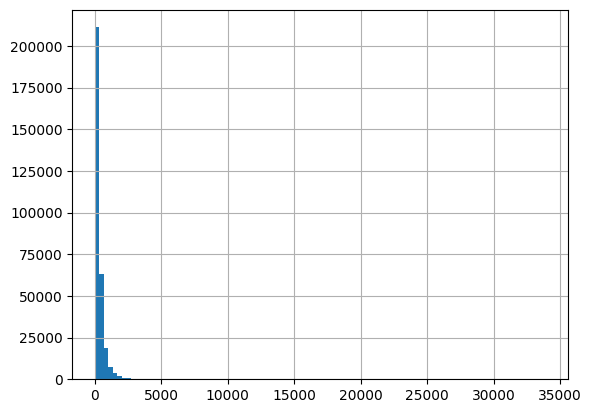

In [42]:
title_lengths.hist(bins=100)

In [43]:
sum(title_lengths > 8291)

35

In [34]:
tiktoken.list_encoding_names()

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base']

In [32]:
import tiktoken

# count the number of tokens in the titles
n_tokens = titles_aggregate_sr.apply(tiktoken.tokenize).apply(len)
n_tokens

AttributeError: module 'tiktoken' has no attribute 'tokenize'

In [ ]:
from slang import fixed_step_chunker
# from dol import JsonFiles
# import oa

# target = JsonFiles('/Users/thorwhalen/tmp/pubs_hcp2')

# for i, chunk in enumerate(fixed_step_chunker(title_store.items(), 10)):
#     ids, titles = zip(*chunk)
#     embeddings = oa.embeddings(list(titles))
#     target[f"{i:03.0f}"].update(dict(zip(ids, embeddings)))
#     break


In [21]:
tt = dacc.titles_aggregate.apply(len)
tt.hist(bins=100)

AttributeError: 'generator' object has no attribute 'apply'

In [ ]:
for i, (citing_id, cited_ids) in enumerate(dacc.titles_aggregate):
    

In [10]:
list(dacc.store)

['planar_cited_mean_embeddings.tsv',
 'planar_cited_normalized_mean_embeddings.tsv.zip',
 'publications-hcp3__.tsv',
 'publications-hcp2-umap.tsv',
 'publications-hcp3__.tsv.zip',
 'planar_cited_mean_embeddings.tsv.zip',
 'publications-hcp2-umap.tsv.zip',
 'planar_cited_normalized_mean_embeddings.tsv',
 'citation-links-hcp3.tsv',
 'publications-hcp2.tsv.zip',
 'publications-hcp2-embeddings.parquet',
 'citation-links-hcp3.tsv.zip']

In [12]:
from dol import Files, FilesOfZip
import pandas as pd

df = pd.read_parquet('/Users/thorwhalen/Downloads/publications-hcp3.parquet')

In [13]:
df.head()

,id,title,abstract,source,pub_date,n_cits,micro_cluster,main_field,title_references
0,245658,Standardized low-resolution brain electromagne...,Scalp electric potentials (electroencephalogra...,PubMed,2002-01-01,1056,241,Biomedical and health sciences,Review of methods for solving the EEG inverse ...
1,332595,Electrokinetic migration across artificial liq...,Basic drug substances were transported across ...,Journal of Chromatography A,2006-03-01,570,180,Physical sciences and engineering,β-Lactamase Recovery from E. coli Cell Lysate ...
2,718838,Pathophysiology of obsessive–compulsive disorder,Obsessive-compulsive disorder (OCD) is charact...,Progress in Neurobiology,2004-02-01,304,1123,Biomedical and health sciences,Elevated medial-frontal cerebral blood flow in...
3,804345,Der Kinder- und Jugendgesundheitssurvey (KiGGS...,"From May 2003 to May 2006, the Robert Koch Ins...",Bundesgesundheitsblatt - Gesundheitsforschung ...,2007-05-01,358,3022,Biomedical and health sciences,Das Landesmodul Schleswig-Holstein im Rahmen d...
4,831416,Remote Ischemic Preconditioning Provides Early...,The aim of this study was to characterize the ...,Journal of the American College of Cardiology,2005-08-01,370,1057,Biomedical and health sciences,Sites of action of adenosine in interorgan pre...


In [18]:
t = df.set_index('id')['title_references']
print(f"{len(t)=}")
title_aggregate_lengths = t.dropna().apply(len)
print(f"{len(title_aggregate_lengths)=}")

len(t)=354165
len(title_aggregate_lengths)=348399


7263

<Axes: >

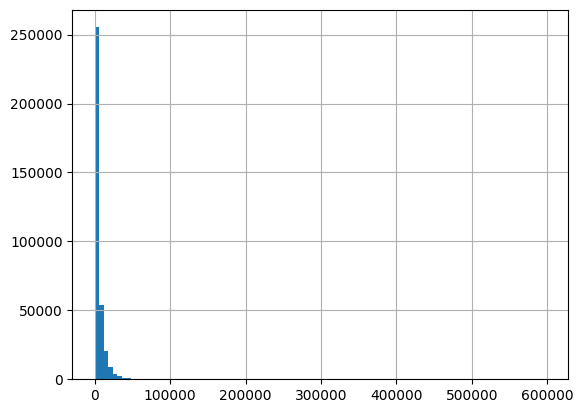

In [20]:
title_aggregate_lengths.hist(bins=100)

In [27]:
titles = dacc.info_hcp2[['id', 'title']].set_index('id')['title']
titles.head()

id
245658    Standardized low-resolution brain electromagne...
332595    Electrokinetic migration across artificial liq...
718838    Pathophysiology of obsessiveâcompulsive diso...
804345    Der Kinder- und Jugendgesundheitssurvey (KiGGS...
831416    Remote Ischemic Preconditioning Provides Early...
Name: title, dtype: object

In [26]:
dacc.citations_and_titles['cited_ids'].head()

0                             [2138790588, 2013150886]
2    [1994893189, 2158553737, 1604916109, 202841896...
4    [2114205159, 2161774890, 1965693998, 211020414...
5                             [2025976960, 2172013173]
6                 [2138019504, 2127271355, 2103972604]
Name: cited_ids, dtype: object

In [25]:
next(iter(dacc.citations_and_titles['cited_ids'].items()))

(0, [2138790588, 2013150886])

In [24]:
k, v = next(t)
k

0

In [19]:
it = titles_aggregate(dacc)
for 

Integration of diverse information in working memory within the frontal lobe

------------------

Tourette's Syndrome

------------------

Neuroimaging and neuropathological studies of depression: implications for the cognitive-emotional features of mood disorders

------------------

Structure and function of dopamine receptors

------------------

Basal ganglia dysfunction in Touretteâs syndrome: a new hypothesis

------------------

A Neural Basis for General Intelligence

------------------

Motivational views of reinforcement: implications for understanding the behavioral functions of nucleus accumbens dopamine

------------------

Mesolimbocortical and nigrostriatal dopamine responses to salient non-reward events

------------------

Gambling Urges in Pathological Gambling

------------------

Contributions of the prefrontal cortex to the neural basis of human decision making

------------------

Decrease in Caudate Glutamatergic Concentrations in Pediatric Obsessive-Compulsive